<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/predict_mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning model for predicting in-hospital mortality
In this example, we will learn how to build a model for predicting in-hospital mortality with <code>VitalDB</code> dataset.<br>

## Preprocessing

In [6]:
import pandas as pd

# Set variables
OUTCOME_VAR = 'death_inhosp'
INPUT_VARS = ['age', 'preop_hb', 'preop_alb', 'preop_ast', 'preop_cr']

# Load dataset
df = pd.read_csv('https://api.vitaldb.net/cases')
df = df[df['asa'] < 6]

# Split a dataset into train and test sets
ntrain = int(len(df) * 0.7)
y_train = df.loc[:ntrain, OUTCOME_VAR]
x_train = df.loc[:ntrain, INPUT_VARS]
y_test = df.loc[ntrain:, OUTCOME_VAR]
x_test = df.loc[ntrain:, INPUT_VARS]

# Print the number of train and test sets
print('{}/{} train, {}/{} test'.format(sum(y_train), len(y_train), sum(y_test), len(y_test)))

37/4274 train, 18/1969 test


## Compute auroc and auprc scores using ASA class

In [7]:
# ASA class
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
y_pred_asa = df.loc[ntrain:, 'asa']

# Compute area under the ROC AUC from prediction scores
auroc_asa = roc_auc_score(y_test, y_pred_asa)

# Compute the precision recall curve
prc_asa, rec_asa, thresholds = precision_recall_curve(y_test, y_pred_asa)

# Compute area under the precision-recall curve
auprc_asa = auc(rec_asa, prc_asa)
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa))

ASA auroc: 0.900, auprc: 0.335


## Modeling with Logistic Regression

In [8]:
# 1 - Logistic regression using SimpleImputer()
from sklearn.impute import SimpleImputer
imp = SimpleImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# 2 - Logistic regression using LogisticRegression()
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(x_train_imputed, y_train)
y_pred_lr = model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_lr = roc_auc_score(y_test, y_pred_lr)
prc_lr, rec_lr, thresholds = precision_recall_curve(y_test, y_pred_lr)
auprc_lr = auc(rec_lr, prc_lr)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr))

LR auroc: 0.947, auprc: 0.236


## Modeling with Gradient Boosting

In [9]:
# 3 - Gradient Boosting using XGBClassifier()
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.07, max_depth=4, n_estimators=50, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss')
model.fit(x_train, y_train)
y_pred_gbm = model.predict_proba(x_test)[:, 1]

# Compute AUROC and AUPRC
auroc_gbm = roc_auc_score(y_test, y_pred_gbm)
prc_gbm, rec_gbm, thresholds = precision_recall_curve(y_test, y_pred_gbm)
auprc_gbm = auc(rec_gbm, prc_gbm)
print('GBM auroc: {:.3f}, auprc: {:.3f}'.format(auroc_gbm, auprc_gbm))

GBM auroc: 0.957, auprc: 0.623


##Plot results

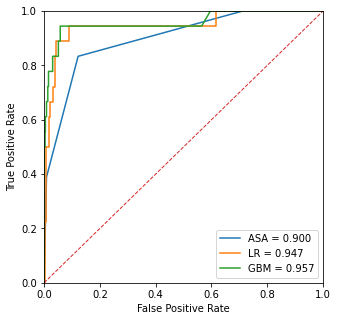

In [13]:
import matplotlib.pyplot as plt

fpr_asa, tpr_asa, _ = roc_curve(y_test, y_pred_asa)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_gbm)

plt.figure(figsize=(5,5))
plt.plot(fpr_asa, tpr_asa, label='ASA = {:0.3f}'.format(auroc_asa))
plt.plot(fpr_lr, tpr_lr, label='LR = {:0.3f}'.format(auroc_lr))
plt.plot(fpr_gbm, tpr_gbm, label='GBM = {:0.3f}'.format(auroc_gbm))
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()